In [1]:
import tensorflow_quantum as tfq
import tensorflow as tf
import cirq
import sympy
import random
import matplotlib.pyplot as plt
import numpy as np

from DataSet import DataSet
from Circuit import Circuit
from qat.interop.cirq import qlm_to_cirq

2024-03-22 13:02:21.609746: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-22 13:02:21.609980: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-03-22 13:02:25.113247: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-03-22 13:02:25.113395: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-03-22 13:02:25.113458: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arturo-virtual-machine): /proc/driver/nvidia/version does not exist
2024-03-22 13:02:25.113845: I tensorflow/core/platform

In [2]:
def make_data_aux(X_values):
    qubit = cirq.LineQubit.range(2)
    train = []
    
    for values in X_values:
        cir = cirq.Circuit()
        for value in values:
            z = sympy.symbols('Y_rot')
            cir.append(cirq.H(qubit[0]))
            cir.append(cirq.H(qubit[1]))
            cir.append(cirq.rz(z).on(qubit[0]) ** value ** 2)
            cir.append(cirq.rz(z).on(qubit[0]) ** value ** 2)
            cir.append(cirq.CNOT(qubit[0], qubit[1]))
            cir.append(cirq.rz(z).on(qubit[1]) ** 2 ** (np.pi - value) ** (np.pi - value))
            cir.append(cirq.CNOT(qubit[0], qubit[1]))
            cir.append(cirq.H(qubit[0]))
            cir.append(cirq.H(qubit[1]))
            cir.append(cirq.rz(z).on(qubit[0]) ** value ** 2)
            cir.append(cirq.rz(z).on(qubit[0]) ** value ** 2)
            cir.append(cirq.CNOT(qubit[0], qubit[1]))
            cir.append(cirq.rz(z).on(qubit[1]) ** 2 ** (np.pi - value) ** (np.pi - value))
            cir.append(cirq.CNOT(qubit[0], qubit[1]))
        train.append(cir)
    return tfq.convert_to_tensor(train)

def make_circuit(qubit):
    y = sympy.symbols('Y_rot')
    c = cirq.Circuit()
    '''
    c.append(cirq.ry(y).on(qubit[0]))
    c.append(cirq.ry(y).on(qubit[1]))
    c.append(cirq.CNOT(qubit[0], qubit[1]))
    c.append(cirq.ry(y).on(qubit[0]))
    c.append(cirq.ry(y).on(qubit[1]))
    c.append(cirq.CNOT(qubit[0], qubit[1]))
    c.append(cirq.ry(y).on(qubit[0]))
    c.append(cirq.ry(y).on(qubit[0]))
    c.append(cirq.CNOT(qubit[0], qubit[1]))
    c.append(cirq.ry(y).on(qubit[0]))
    c.append(cirq.ry(y).on(qubit[1]))
    
    c.append(cirq.ry(y).on(qubit[0]))
    c.append(cirq.CNOT(qubit[0], qubit[1]))
    c.append(cirq.ry(y).on(qubit[1]))
    c.append(cirq.CNOT(qubit[0], qubit[1]))
    c.append(cirq.X(qubit[0]))
    c.append(cirq.ry(y).on(qubit[1]))
    c.append(cirq.CNOT(qubit[0], qubit[1]))
    c.append(cirq.ry(y).on(qubit[1]))
    c.append(cirq.CNOT(qubit[0], qubit[1]))
    c.append(cirq.X(qubit[0]))
    c.append(cirq.ry(y).on(qubit[1]))
    '''
    c.append(cirq.H(qubit[0]))
    c.append(cirq.CNOT(qubit[0], qubit[1]))
    c.append(cirq.rz(y).on(qubit[0]))
    c.append(cirq.rz(y).on(qubit[1]))
    c.append(cirq.CNOT(qubit[0], qubit[1]))
    c.append(cirq.H(qubit[0]))
    
    return c

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

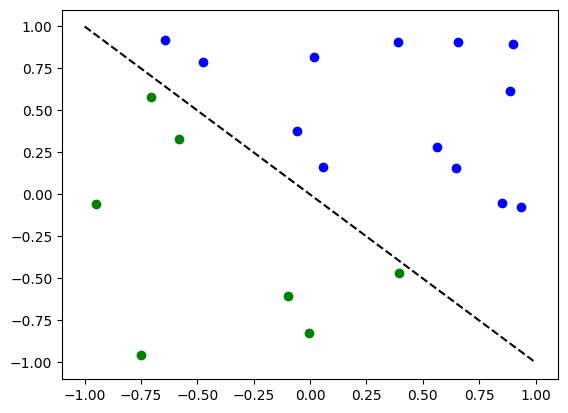

In [3]:
dataset = DataSet()
dataset.Draw()

In [4]:

circuit = Circuit()
circuit.varCircuit3()
#circuit.ZZFeatureMap()
cirq_circuit = qlm_to_cirq(circuit.circuit())

no_measurements_circuit = cirq.drop_terminal_measurements(cirq_circuit)

train = make_data_aux(dataset.X_aux)

qubit = cirq.LineQubit.range(2)
cirq_circuit_2 = make_circuit(qubit)
readout_operators = [cirq.X(qubit[0])]
inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)

layer1 = tfq.layers.PQC(cirq_circuit, readout_operators, repetitions=32, differentiator=tfq.differentiators.ParameterShift(), initializer=tf.keras.initializers.Zeros)(inputs)
model = tf.keras.models.Model(inputs=inputs, outputs=layer1)
model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.hinge, metrics=[hinge_accuracy])

history = model.fit(train, dataset.y, epochs=1, batch_size=32)

/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


1/1 [==============================] - 3s 3s/step - loss: 1.0438 - hinge_accuracy: 0.5000


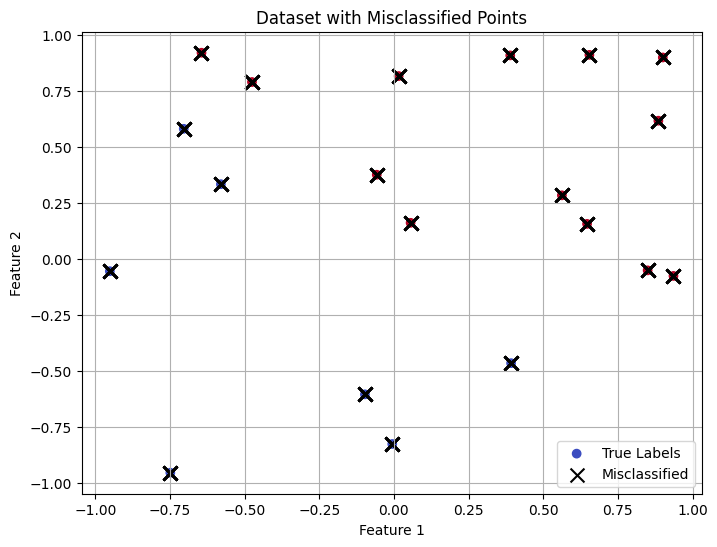

In [5]:
# Obtener predicciones del modelo para el conjunto de datos
predictions = model.predict(train)

# Convertir las predicciones a etiquetas (1 si la predicción es positiva, -1 si es negativa)
predicted_labels = np.sign(predictions)

# Obtener las etiquetas verdaderas del dataset
true_labels = dataset.y

# Encontrar los índices de los puntos mal clasificados
misclassified_indices = np.where(predicted_labels != true_labels)[0]

# Graficar los puntos del dataset
plt.figure(figsize=(8, 6))
plt.scatter(dataset.X_aux[:, 0], dataset.X_aux[:, 1], c=true_labels, cmap='coolwarm', label='True Labels')

# Resaltar los puntos mal clasificados
if len(misclassified_indices) > 0:
    plt.scatter(dataset.X_aux[misclassified_indices, 0], dataset.X_aux[misclassified_indices, 1],
                marker='x', s=100, c='black', label='Misclassified')

plt.title('Dataset with Misclassified Points')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()